In [4]:
from sgp4.api import Satrec
from astropy.coordinates import *
from astropy import units as u
from astropy.time import Time
import numpy as np  
import matplotlib.pyplot as plt

from pathlib import Path
import sys

Reading NORAD TLE

In [5]:
def parse_tle_file(file_content):
    lines = file_content.strip().split('\n')
    result = {}
    i = 0
    while i < len(lines):
        line = lines[i].strip()
        if "OBJECT" in line:
            object_name = line.strip()
            if i + 2 < len(lines):
                line1 = lines[i + 1].strip()
                line2 = lines[i + 2].strip()
                result[object_name] = (line1, line2)
                i += 3
            else:
                break
        else:
            i += 1
    
    return result

FILEPATH = Path("/Users/peppedilillo/Desktop/tle_check/norad.txt")
with open(FILEPATH, 'r') as file:
    content = file.read()

tle_data = parse_tle_file(content)

Propagating NORAD TLE:

In [6]:
tref = Time("2025-03-28 20:54:50", format='iso')

propagated = {}
for satname in tle_data:
    sat = Satrec.twoline2rv(*tle_data[satname])
    error, r, v = sat.sgp4(tref.jd1, tref.jd2)
    propagated[satname] = (error, np.array(r), np.array(v))

Reading HERMES data

In [9]:
H1 = (
    np.array((-3264.3768, 219.0079, 5902.4429)),
    np.array((-6.1285, 2.3917, -3.4702)),
)

H1_ERR = (
    np.array((1157.8453, 450.0390, 676.9687)),
    np.array((0.7632, .0869, 1.3567)),
)

H2 = (
    np.array((-5756.2715, 1337.4833, 3359.0302)),
    np.array((-3.3279, 1.9151, -6.4542)),
)

In [10]:
diffs = {}
for satname in propagated:
    dr = np.linalg.norm(H1[0] -  propagated[satname][1]) / np.linalg.norm(H1_ERR[0])
    dv = np.linalg.norm(H1[1] -  propagated[satname][2]) / np.linalg.norm(H1_ERR[1])
    diffs[satname] = (0, dr, dv)

In [11]:
x, y = zip(*[(dr, dv) for _, dr, dv in diffs.values()])

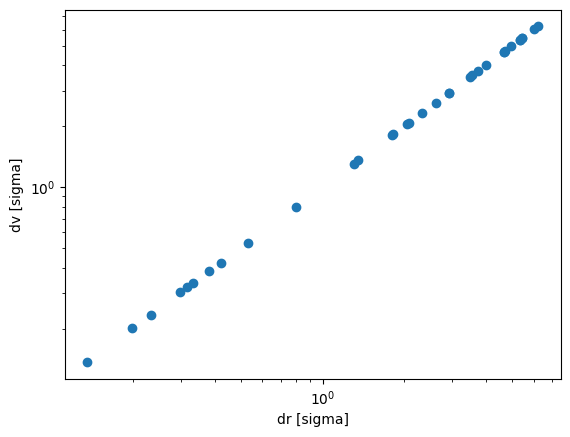

In [16]:
plt.scatter(x, y)
plt.xlabel("dr [sigma]")
plt.ylabel("dv [sigma]")
plt.loglog()
plt.show()